# STAC API with RasterFrames Notebook

## Setup Spark Environment

In [1]:
import pyrasterframes
from pyrasterframes.utils import create_rf_spark_session
import pyrasterframes.rf_ipython  # enables nicer visualizations of pandas DF
from pyrasterframes.rasterfunctions import *
import pyspark.sql.functions as F


In [2]:
spark = create_rf_spark_session()

bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by bash)
bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by bash)
21/10/01 00:25:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Get a STAC API DataFrame

Read a DataFrame that consists of STAC Items retrieved from the STAC API service.

In [3]:
# read assets from the landsat-8-l1-c1 collection
# due to the collection size and query parameters
# it makes sense to limit the amount of items retrieved from the STAC API
uri = 'https://earth-search.aws.element84.com/v0'
df = spark.read.stacapi(uri, {'collections': ['landsat-8-l1-c1']}, search_limit=100)

In [4]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- stacVersion: string (nullable = true)
 |-- stacExtensions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- _type: string (nullable = true)
 |-- geometry: geometry (nullable = true)
 |-- bbox: struct (nullable = true)
 |    |-- xmin: double (nullable = true)
 |    |-- ymin: double (nullable = true)
 |    |-- xmax: double (nullable = true)
 |    |-- ymax: double (nullable = true)
 |-- links: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- href: string (nullable = true)
 |    |    |-- rel: string (nullable = true)
 |    |    |-- _type: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- extensionFields: string (nullable = true)
 |-- assets: map (nullable = true)
 |    |-- key: string
 |    |-- value: struct (valueContainsNull = true)
 |    |    |-- href: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- desc

Each item in the DataFrame represents the entire STAC Item.

In [5]:
df.count()

100

In [6]:
df.select(df.id, df.collection, df.geometry)

id,collection,geometry
LC08_L1TP_232093_20210716_20210717_01_T1,landsat-8-l1-c1,POLYGON ((-74.64766964714028 -46.3435154...
LC08_L1TP_232092_20210716_20210717_01_T1,landsat-8-l1-c1,POLYGON ((-74.07682865409966 -44.9166888...
LC08_L1TP_232091_20210716_20210717_01_T1,landsat-8-l1-c1,POLYGON ((-73.54155930424828 -43.4885910...
LC08_L1TP_232090_20210716_20210717_01_T1,landsat-8-l1-c1,POLYGON ((-73.02667875381594 -42.0589406...
LC08_L1TP_232089_20210716_20210717_01_T1,landsat-8-l1-c1,POLYGON ((-72.67424121162182 -40.6804236...


To read rasters we don't need STAC Items, but we need STAC Item Assets.
Each STAC Item in the DataFrame can contain more than a single asset => to covert such STAC Item DataFrame into the STAC Item Assets DataFrame we need to explode the assets column. 

In [7]:
# select the first Landsat STAC Item
# explode its assets 
# select blue, red, green, and nir assets only
# name each asset link as the band column
assets = df \
  .limit(1) \
  .select(df.id, F.explode(df.assets)) \
  .filter(F.col("key").isin(["B2", "B3", "B4", "B5"])) \
  .select(F.col("value.href").alias("band"))

In [8]:
assets.printSchema()

root
 |-- band: string (nullable = true)



In [9]:
assets.count()

4

In [10]:
# read rasters from the exploded STAC Assets DataFrame
# select only the blue asset to speed up notebook
rs = spark.read.raster(assets.limit(1), tile_dimensions=(512, 512), buffer_size=2, catalog_col_names=["band"])

In [11]:
rs.count()

256

In [12]:
rs.printSchema()

root
 |-- band_path: string (nullable = false)
 |-- band: struct (nullable = true)
 |    |-- tile: tile (nullable = true)
 |    |-- extent: struct (nullable = true)
 |    |    |-- xmin: double (nullable = false)
 |    |    |-- ymin: double (nullable = false)
 |    |    |-- xmax: double (nullable = false)
 |    |    |-- ymax: double (nullable = false)
 |    |-- crs: crs (nullable = true)



## Focal Operations
Additional transformations are complished through use of column functions.
The functions used here are mapped to their Scala implementation and applied per row.
For each row the source elevation data is fetched only once before it's used as input.

rf_crs(band),rf_extent(band),rf_aspect(band),"rf_slope(band, 1)","rf_hillshade(band, 315, 45, 1)"
utm-CS,"{488445.0, -5335365.0, 503805.0, -5320005.0}",,,
utm-CS,"{657405.0, -5335365.0, 672765.0, -5320005.0}",,,
utm-CS,"{688125.0, -5335365.0, 703485.0, -5320005.0}",,,
utm-CS,"{642045.0, -5197125.0, 657405.0, -5181765.0}",,,
utm-CS,"{549885.0, -5366085.0, 565245.0, -5350725.0}",,,

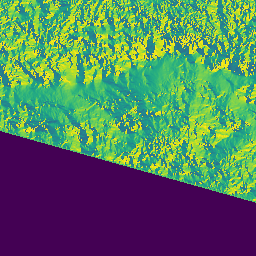
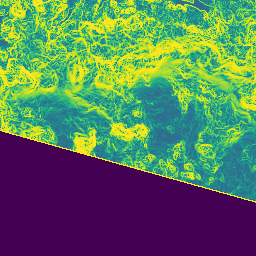
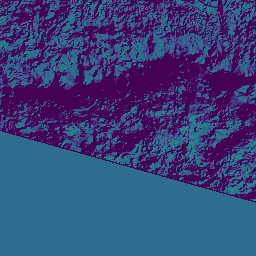
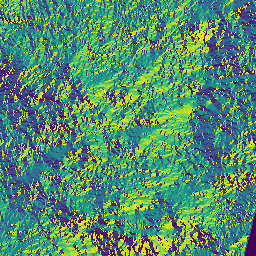
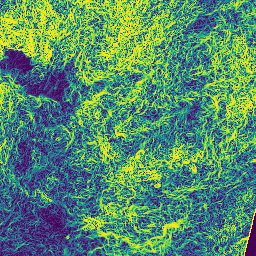
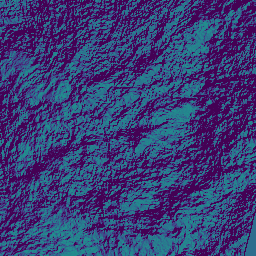
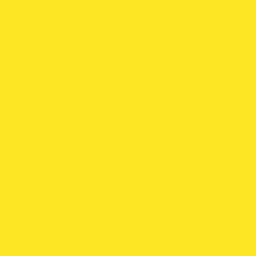
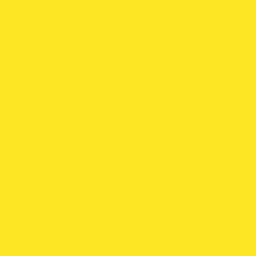
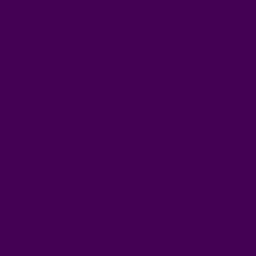
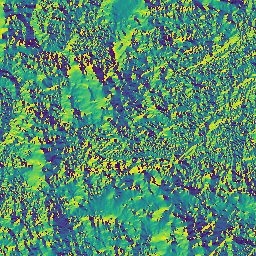
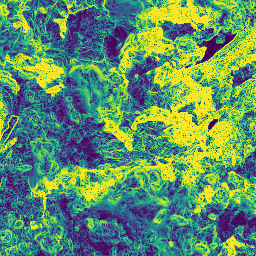
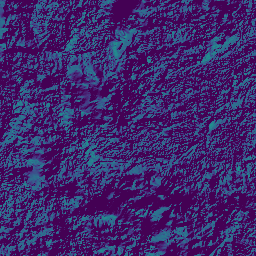
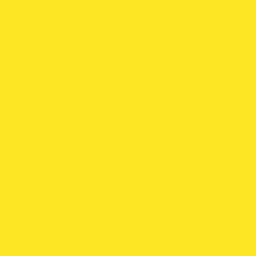
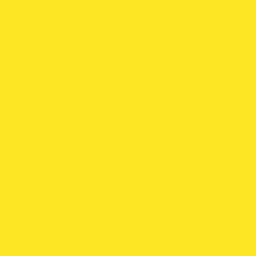
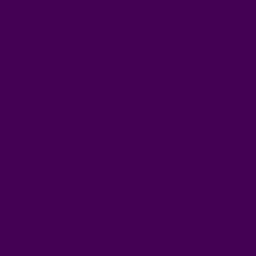

In [13]:
rs.select(
    rf_crs(rs.band), 
    rf_extent(rs.band), 
    rf_aspect(rs.band), 
    rf_slope(rs.band, z_factor=1), 
    rf_hillshade(rs.band, azimuth=315, altitude=45, z_factor=1))